In [119]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import sys 
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import data_fit as df
import importlib
importlib.reload(data_fit)

<module 'data_fit' from '/home/dave/Desktop/Fall 2020/analysis/data_fit.py'>

In [125]:
def residual(p,func, xvar, yvar, err):
    return (func(p, xvar) - yvar)/err

def fit_model(p, x):
    # p = [N, mu, sigma, m, b]
    N = p[0]
    mu = p[1]
    sigma = p[2]
    m = p[3]
    b = p[4]
    # model to be fitted
    return N/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((x - mu)/sigma)**2) + m*x + b

def cs_fit_model(p, x):
    # p = [lambda]
    return np.exp(-1*p[0]*x)

class Analysis:
    # thickness expected in mm
    # expect Channel and Counts fields in data
    def __init__(self, filename, thickness, low, high, f=None, init_plot=False):
        # doing cut arbitrarily by eye here 
        # come up with better estimate for this
        if not f: self.file = sys.stdout
        else: self.file = f
        self.pf, self.pferr, self.chisq,self.dof = None, None, None, None
        self.fited = None
        self.thickness = thickness
        self.low = low
        self.high = high
        self.data_start = 1
        # self.data = [chan_arr, count_arr]
        self.data = np.loadtxt(filename , unpack=True, skiprows = self.data_start, delimiter = ",")  
        self.chan = self.data[0][self.low:self.high]
        self.N = self.data[1][self.low:self.high]
        self.dN = np.sqrt(self.N)
        # for any dN = 0, set dN = 1.14 (see justification for this)
        for i, value in enumerate(self.N):
            if value == 0: self.dN[i] = 1.14
        
        if init_plot:
            # make this nicer to get a single plot
            fig, ax = plt.subplots(figsize=(6,4))
            ax.errorbar(self.chan, self.N, self.dN, fmt='k.', capsize=3)
    
    # The code below defines our data fitting function.
    # Inputs are:
    # initial guess for parameters p0
    # the function we're fitting to
    # the x,y, and dy variables
    # tmi can be set to 1 or 2 if more intermediate data is needed

    def data_fit(self, p0,func,xvar, yvar, err,tmi=0):
        try:
            fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err),verbose=tmi)
        except Exception as error:
            print("Something has gone wrong:",error, file=self.file)
            return p0,np.zeros_like(p0),-1,-1
        self.pf = fit['x']

        print(" ", file=self.file)

        try:
            cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))          
            # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
            # We need this to find the uncertainty in our fit parameters
        except:
            # If the fit failed, print the reason
            print('Fit did not converge', file=f)
            print('Result is likely a local minimum', file=self.file)
            print('Try changing initial values', file=self.file)
            print('Status code:', fit['status'], file=self.file)
            print(fit['message'], file=self.file)
            return self.pf,np.zeros_like(self.pf),-1,-1
            #You'll be able to plot with this, but it will not be a good fit.

        self.chisq = sum(residual(self.pf,func,xvar, yvar, err) **2)
        self.dof = len(xvar) - len(self.pf)
        self.red_chisq = self.chisq/self.dof
        self.pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
        print('Thickness: ' + self.thickness, file=self.file)
        print('Converged with chi-squared {:.2f}'.format(self.chisq), file=self.file)
        print('Number of degrees of freedom, dof = {:.2f}'.format(self.dof), file=self.file)
        print('Reduced chi-squared {:.2f}'.format(self.red_chisq), file=self.file)
        print(" ", file=self.file)
        Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
        print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]), file=self.file)
        for num in range(len(self.pf)):
            print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(self.pf[num]),'|','{:<24.3e}'.format(self.pferr[num]), file=self.file)
        return self.pf, self.pferr, self.chisq,self.dof
    
    def fit(self, p0):
        # returns fited function f(x)
        if self.pf is None:
            self.pf, self.pferr, self.chisq, self.dof = self.data_fit(p0, fit_model, self.chan, self.N, self.dN)
        self.fited = lambda x: fit_model(self.pf, x)
        return self.fited
    
    def compute_gamma_num(self, p0): 
        # returns gamma_num, error
        if self.pf is None: self.fit(p0)
        return self.pf[0], self.pferr[0]
    
    def plot(self, p0, ax):
        # modifies axis object with data, lables and title
        # correctly styled
        if self.fited is None or self.pf is None: self.fit(p0)

        if ax is None: ax = plt.gca() # get current axis
        
        X = np.linspace(self.chan.min(), self.chan.max(), 500)
        ax.errorbar(self.chan, self.N, self.dN, fmt='ko', label = 'Data', capsize=1)
        ax.plot(X, self.fited(X), 'r-', label = 'Fit')

        ax.set_title('Thickness: '+self.thickness)
        ax.set_xlabel('Channel')
        ax.set_ylabel('Counts')

        # Here is the text we want to include...
        #textfit = '$f(x) = A/\\sigma \\sqrt{2\\pi} exp(\\frac{-(x - \\mu)^2}{2\\sigma^2}) + mx + b$ \n' 
        textfit = '$N = {:.2f} \pm {:.2f}$ counts \n'.format(self.pf[0],self.pferr[0]) 
        textfit +='$\\mu = {:.2f} \pm {:.2f}$ counts\n'.format(self.pf[1],self.pferr[1]) 
        textfit +='$\\sigma = {:.2f} \pm {:.2f}$ \n'.format(self.pf[2],self.pferr[2]) 
        textfit +='$m = {:.2f} \pm {:.2f}$ counts/channel \n'.format(self.pf[3],self.pferr[3])
        textfit +='$b = {:.2f} \pm {:.2f}$ counts \n'.format(self.pf[4],self.pferr[4]) 

        textfit2 = '$\chi^2= {:.1f}$ \n'.format(self.chisq) 
        textfit2 += '$N = {}$ (dof) \n'.format(self.dof) 
        textfit2 += '$\chi^2/N = {:.2f}$'.format(self.chisq/self.dof) 

        #... and below is where we actually place it on the plot
        ax.text(0.65, 0.85, textfit, transform=ax.transAxes , fontsize=10,verticalalignment='top')
        ax.text(0.05, 0.95, textfit2, transform=ax.transAxes , fontsize=12,verticalalignment='top')


        ax.set_xlim([self.chan.min()-0.5, self.chan.max()+0.5])
        # this ensures that the axes always scale to be just slightly wider than the data.
        ax.legend(loc='upper right')
        return None

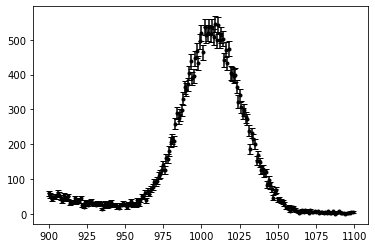

In [126]:
path = 'first_pass_data/2020_10_8/'
files = [f for f in listdir(path) if isfile(join(path, f))]

test = Analysis(path+files[0], files[0][:-4], 900, 1100, init_plot=True)

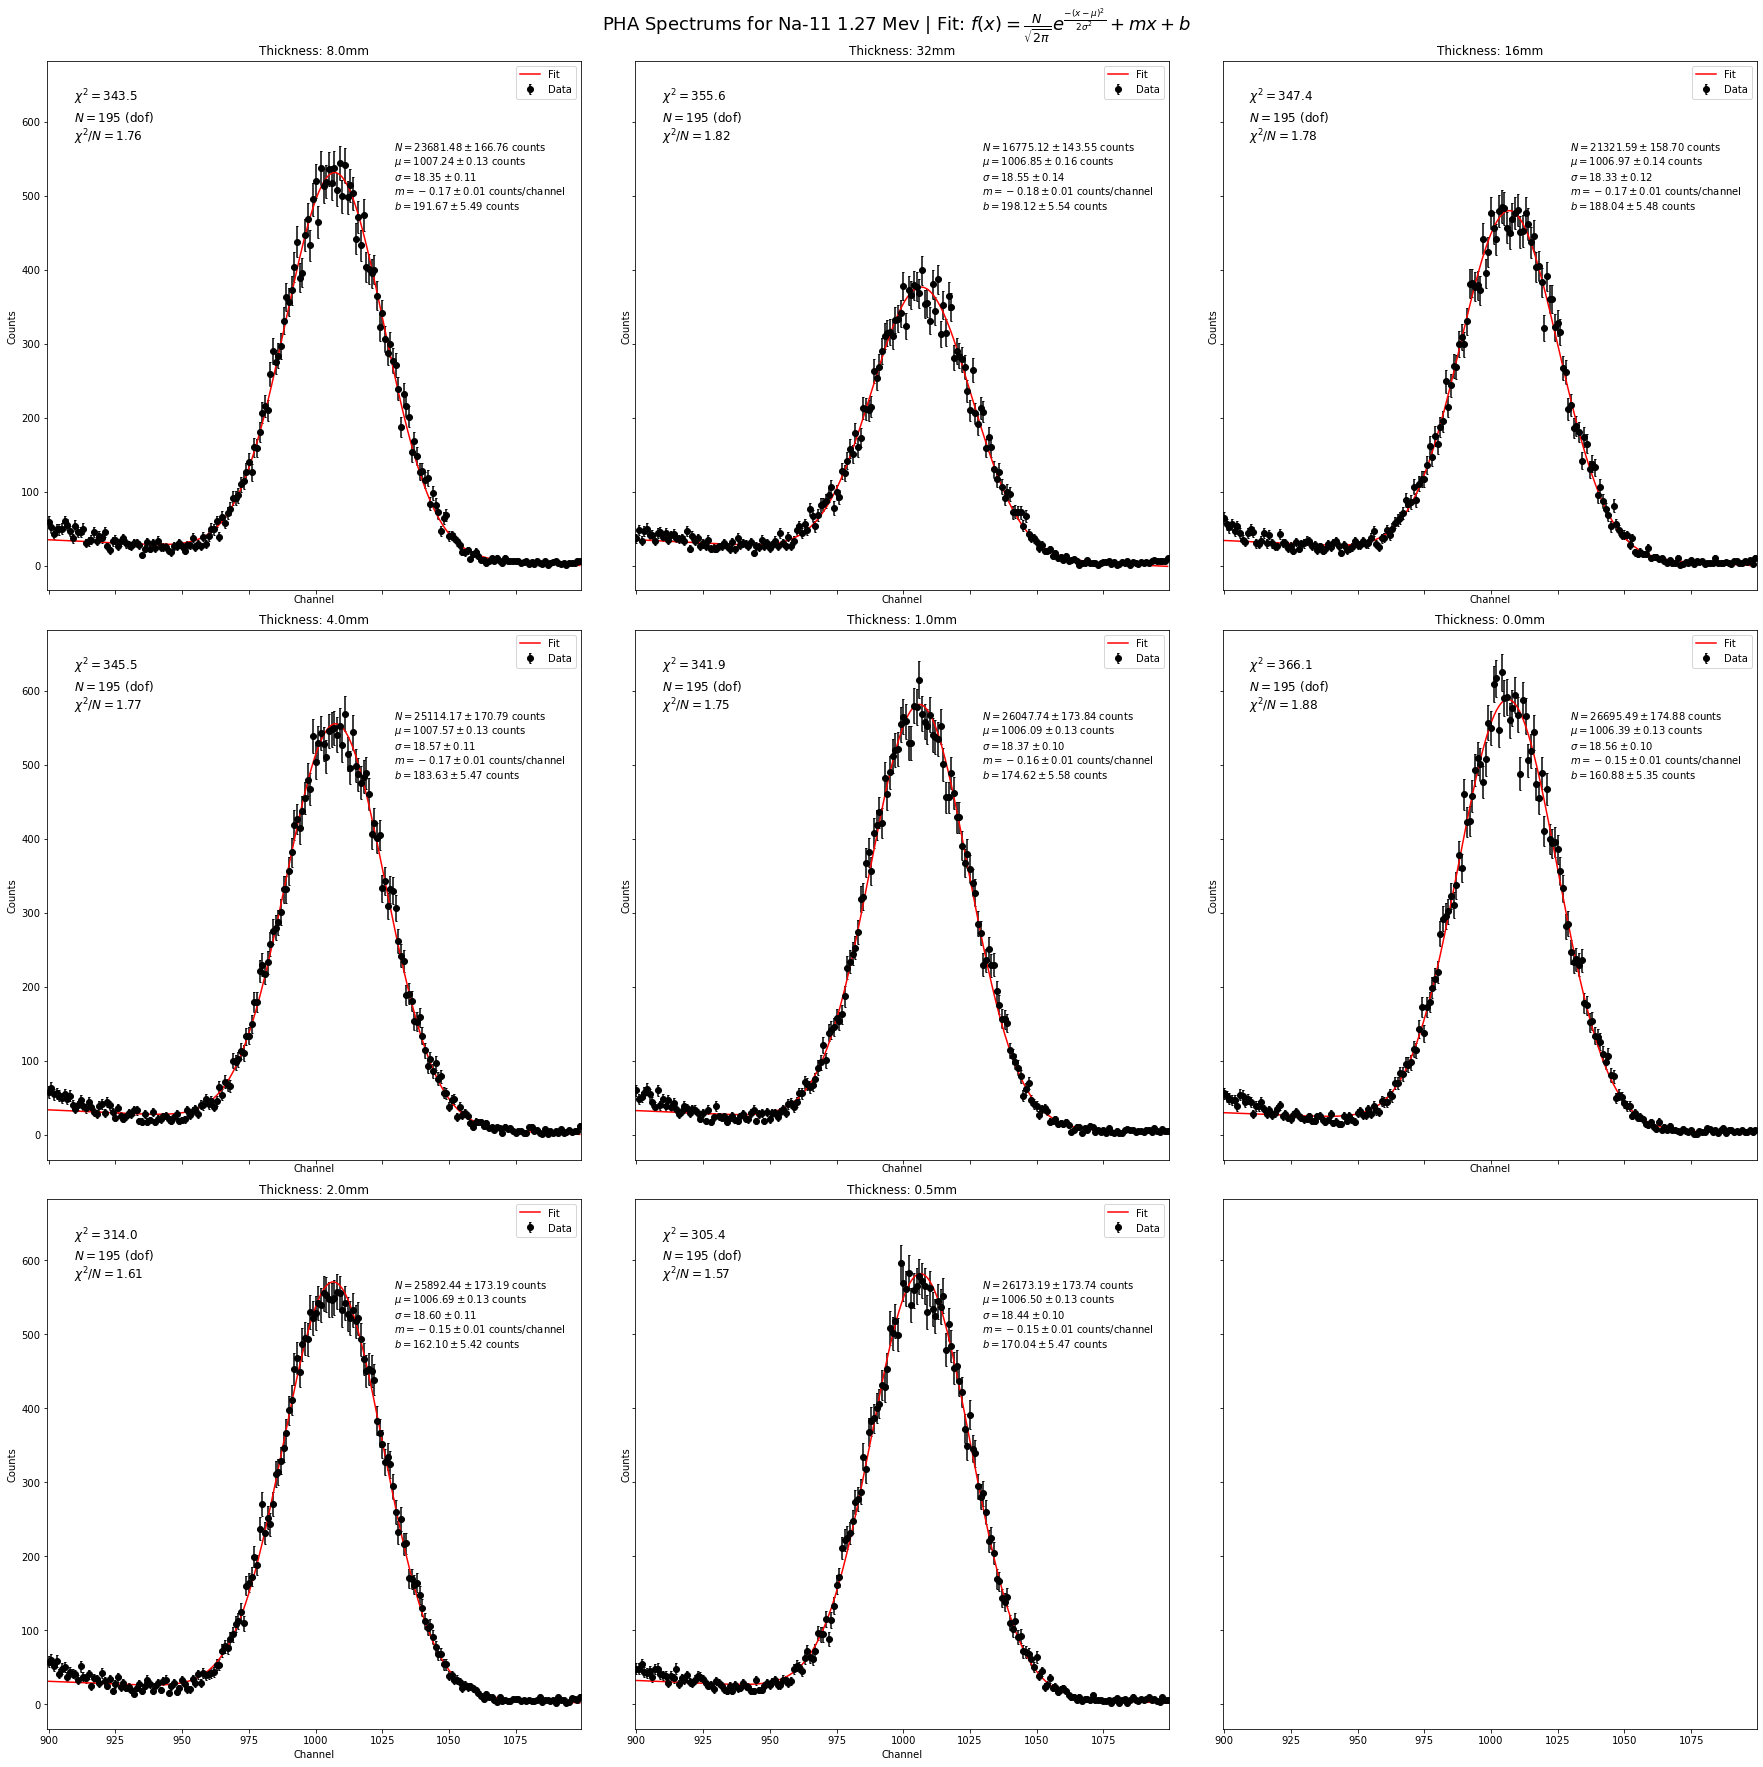

In [127]:
photon_nums = {} # thicknes : (nums, error (in integrating))
# p = [N, mu, sigma, m, b]
p0 = [26000, 1000, 30, -0.5, 0.5] # init  param guess for fitting

# test fit params p0
#fig, ax = plt.subplots(figsize=(6,4))
#ax.plot(test.chan, fit_model(p0, test.chan), 'r-')
outfile = 'Na11_1.27mev.txt'
with open(outfile, "w+") as f:
    data = f.read()

fig, axes = plt.subplots(ncols=3,nrows=3, sharex=True, sharey=True, figsize=(25,25))
with open(outfile, 'w') as f:
    for i, file in enumerate(files):
        thickness = file[:-4] # some slice
        analysis = Analysis(path+file, thickness, 900, 1100, f)
        photon_nums[thickness] = tuple(analysis.compute_gamma_num(p0))
        ax = axes.flat[i] # get the ith axis and pass to plot method
        analysis.plot(p0, ax)

title = "PHA Spectrums for Na-11 1.27 Mev | Fit: $f(x) = \\frac{N}{\\sqrt{2\\pi}}e^{\\frac{-(x - \\mu)^2}{2\\sigma^2}} + mx + b$"
fig.suptitle(title, fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig("PHA_spectrums_for_Na-11_1.27Mev.pdf")
plt.show()

In [128]:
print(photon_nums)
[(n[0]/900, n[1]/900) for n in photon_nums.values()]

{'8.0mm': (23681.476966004982, 166.75649269900586), '32mm': (16775.116383398246, 143.5497642232469), '16mm': (21321.588905778386, 158.700770666189), '4.0mm': (25114.165139519155, 170.7946893960729), '1.0mm': (26047.74248612735, 173.84421290175771), '0.0mm': (26695.48932258867, 174.87776453446816), '2.0mm': (25892.438289766447, 173.18579589567383), '0.5mm': (26173.18742258061, 173.73857201447981)}


[(26.31275218444998, 0.1852849918877843),
 (18.63901820377583, 0.1594997380258299),
 (23.690654339753763, 0.1763341896290989),
 (27.904627932799063, 0.18977187710674767),
 (28.941936095697056, 0.19316023655750858),
 (29.6616548028763, 0.19430862726052017),
 (28.769375877518275, 0.19242866210630427),
 (29.0813193584229, 0.19304285779386646)]


Converged with chi-squared 3.21
Number of degrees of freedom, dof = 5.00
Reduced chi-squared 0.64

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 3.000e+01                | 2.944e+01                | 1.016e-01               
1           | 2.000e+00                | -9.843e-02               | 1.940e-02               
2           | -1.000e+01               | -6.777e+00               | 7.889e-01               


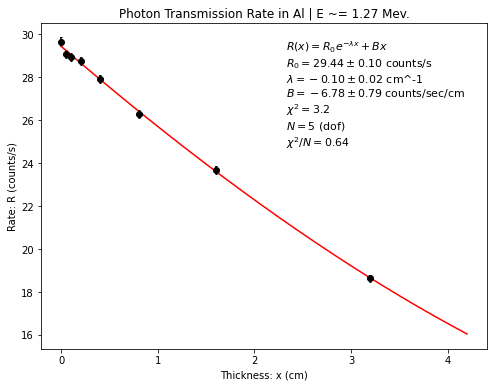

In [140]:
# we fit the rate of detection of photons 
# collection took place for 15 mins for Na-11 data
collection_time = 15 * 60
thickness = np.array([float(s[:-2]) / 10 for s in photon_nums.keys()])
nums = np.array([s[0] for s in photon_nums.values()])
rates = nums / collection_time
errors = np.array([s[1]/collection_time for s in photon_nums.values()])

# fitting: R(x) = R_0exp(-lambda * x) + Bx where x is thickness 
# linear term in the rate because the larger the thicknes, the 
# lower the rate of photons escaping the barrier
def rate_model(p, x):
    # p = [R_0, lambda, B]
    return p[0]*np.exp(-x*p[1]) + p[2]*x


p0 = [30, 2, -10]
rpf, rpferr, rchisq, rdof = df.data_fit(p0, rate_model, thickness, rates, errors)

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(thickness, rates, errors, fmt='ko', label = 'Data', capsize=1)
X = np.linspace(0, thickness.max()+1, 500)
ax.plot(X, rate_model(rpf, X), 'r-', label='Fit')

textfit = '$R(x) = R_0e^{-\\lambda x} + Bx$ \n'
textfit += '$R_0 = {:.2f} \pm {:.2f}$ counts/s \n'.format(rpf[0],rpferr[0]) 
textfit +='$\\lambda = {:.2f} \pm {:.2f}$ cm^-1 \n'.format(rpf[1],rpferr[1]) 
textfit +='$B = {:.2f} \pm {:.2f}$ counts/sec/cm \n'.format(rpf[2],rpferr[2]) 
textfit += '$\\chi^2= {:.1f}$ \n'.format(rchisq) 
textfit += '$N = {}$ (dof) \n'.format(rdof) 
textfit += '$\\chi^2/N = {:.2f}$'.format(rchisq/rdof) 

ax.text(0.55, 0.95, textfit, transform=ax.transAxes , fontsize=11,verticalalignment='top')

ax.set_title('Photon Transmission Rate in Al | E ~= 1.27 Mev.')
ax.set_xlabel('Thickness: x (cm)')
ax.set_ylabel('Rate: R (counts/s)')
plt.savefig("Rates_Na11_1.27Mev.pdf")

In [141]:
# get cross section value by relating the linear attinuation factor 
# to the corss section by some formula for Al